Problem 3

In [43]:
import numpy as np
import matplotlib.pyplot as plt

Circular Data is generated using `numpy.sin` and `numpy.cos` to generate points that lie on the circumference of a circle, and noise is added through `np.random.normal` to give the data some variation

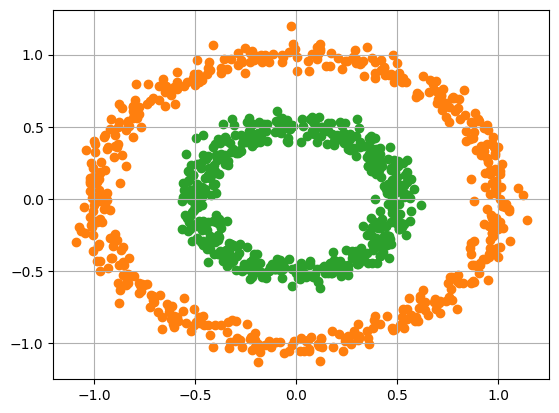

In [44]:
t = np.linspace(-5, 5, 500)
x1 = np.sin(np.pi*t) + np.random.normal(0, 0.05, 500)
y1 = np.cos(np.pi*t) + np.random.normal(0, 0.05, 500)
plt.scatter(x1, y1, s = 10)

x2 = 0.5*np.sin(np.pi*t) + np.random.normal(0, 0.05, 500)
y2 = 0.5*np.cos(np.pi*t) + np.random.normal(0, 0.05, 500)


D1 = np.concatenate((x1.reshape((500,1)), y1.reshape(500,1)), axis=1)
D2 = np.concatenate((x2.reshape((500,1)), y2.reshape(500,1)), axis=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.grid()
plt.show()

X = np.concatenate((D1, D2), axis=0)
Y = np.ones(np.size(X,0))
Y[500:] = 0

In [45]:
X = X.T
print(X.shape)
Y = (Y.T).reshape((1, X.shape[1]))
print(Y.shape)
# print(Y)

(2, 1000)
(1, 1000)


The function below establishes the number of neurons in each of the three layers by extracting them from the dataset

In [46]:
def get_layers(x, y):
  input_layer_count = X.shape[0]
  hidden_layer_count = 5
  output_layer_count = Y.shape[0]
  return (input_layer_count, hidden_layer_count, output_layer_count)

nb_input_nodes, nb_hidden_nodes, nb_output_nodes = get_layers(X, Y)
print("Input Layer Size {}".format(nb_input_nodes))
print("Hidden Layer Size {}".format(nb_hidden_nodes))
print("Output Layer Size {}".format(nb_output_nodes))
  

Input Layer Size 2
Hidden Layer Size 5
Output Layer Size 1


The parameters $W$ and $b$ are initialized with random values

The meanings of the variables are as follows:  
`W1` and `W2` are the weight matrices between the first and hidden layers, and the hidden and output layers, respectively  
`b1` and `b2` are the bias vectors for the hidden layer and the output layer

In [47]:
def initialization(nb_input_nodes, nb_hidden_nodes, nb_output_nodes):
  W1 = np.random.randn(nb_hidden_nodes, nb_input_nodes)
  W2 = np.random.randn(nb_output_nodes, nb_hidden_nodes)

  b1 = np.zeros((nb_hidden_nodes, 1))
  b2 = np.zeros((nb_output_nodes, 1))

  params = [W1, b1, W2, b2]
  return params

For activation, I have used the sigmoid function

In [48]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

The forward propagation procedure takes the parameters of the network as well as its input features as input, and returns the output of the final layer. In this case, the final layer is a single node, whose activation is a measure of the probability of the input instance belonging to one of the two classes.  
As a side effect, it stores and returns the values for the activations as well as the $Z$-vectors of the hidden and output layers

In [49]:
def forwardProp(x, params):
  W1 = params[0]
  b1 = params[1]
  W2 = params[2]
  b2 = params[3]

  Z1 = np.dot(W1, x) + b1
  A1 = sigmoid(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2)

  stored = {
    "Z1": Z1,
    "A1": A1,
    "Z2": Z2,
    "A2": A2
  }

  return A2, stored

For classification, I have used cross entropy, since it is more suited for classification problems. The formulation of loss is given as:
$$
  J = \frac{1}{m} \sum_{i=1}^{m} (y^{(i)} log(a^{(2), (i)}) + (1 - y^{(i)})log(1 - a^{(2),(i)}))
$$
Where $y^{(i)}$ is the class for the $i^{th}$ element in the dataset and $a^{(2), (i)}$ is the activation from the output layer, for the $i^{th}$ element in the dataset

In [50]:
def cross_entropy_loss(a2, y, params):
  m = y.shape[1]
  log_probabilities = np.multiply(np.log(a2), Y) + np.multiply((1-Y), np.log(1 - a2)) # direct implementation of the equation above
  loss = -np.sum(log_probabilities) / m
  loss = float(np.squeeze(loss))

  return loss

Backpropagation is done manually for each parameter, with the expressions in code being implementations of the equations from Andrew Ng's Deep Learning Specialization Course (Week 3), also given below


$$
dZ^{(2)} = A^{(2)} - Y  \\
dW^{(2)} = \frac{1}{m}dZ^{(2)}\dot A^{(1)T} \\
db^{(2)} = \frac{1}{m}np.sum(dZ^{(2)}, axis = 1, keepDims = True)\\
dZ^{(1)} = W^{(2)T}\dot dZ^{(2)}\star g'(Z^{(1)}) \\
dW^{(1)} = \frac{1}{m}dZ^{(1)}X^T
db^{(1)} = \frac{1}{m}np.sum(dZ^{(1)}, axis = 1, keepDims = True)
$$

In [51]:
def backprop(params, stored, x, y):
  m = y.shape[1]

  W1 = params[0]
  W2 = params[2]

  A1 = stored['A1']
  A2 = stored['A2']

  delZ2 = A2 - Y
  delW2 = np.dot(delZ2, A1.T) / m
  delb2 = np.sum(delZ2, axis = 1, keepdims=True) / m
  delZ1 = np.multiply(np.dot(W2.T, delZ2), 1 - np.power(A1, 2))
  delW1 = np.dot(delZ1, X.T) / m
  delb1 = np.sum(delZ1, axis = 1, keepdims=True) / m

  gradient = {
    "W1": delW1,
    "b1": delb1,
    "W2": delW2,
    "b2": delb2
  }

  return gradient

The gradient descent step is done manually as well, for each layer of the network

In [52]:
def gradient_descent(params, gradient, eta = 0.1):
  W1 = params[0]
  b1 = params[1]
  W2 = params[2]
  b2 = params[3]

  delW1 = gradient["W1"]
  delb1 = gradient["b1"]
  delW2 = gradient["W2"]
  delb2 = gradient["b2"]


  W1 = W1 - eta * delW1
  b1 = b1 - eta * delb1
  W2 = W2 - eta * delW2
  b2 = b2 - eta * delb2

  params = [W1, b1, W2, b2]

  return params


Below is the driver function that ties it all together. For however many epochs is given as input, the function will perform forward propagation for the entire dataset, calculate the loss incurred by the current configuration of the network, and backpropagate that loss to adjust the weights and biases across the layers, after which it once again performs forward propagation with the new configuration of the dataset. It iterates for the number of epochs `nb_epochs`, given as input

In [53]:

def MLP(x, y, nb_hidden_nodes, nb_epochs = 100):
  np.random.seed(42)
  nb_input_nodes = get_layers(x, y)[0]
  nb_output_nodes = get_layers(x, y)[2]

  params = initialization(nb_hidden_nodes=nb_hidden_nodes, nb_output_nodes=nb_output_nodes, nb_input_nodes=nb_input_nodes)

  W1 = params[0]
  b1 = params[1]
  W2 = params[2]
  b2 = params[3]

  for i in range(0, nb_epochs):
    A2, stored = forwardProp(x=x, params=params)
    loss = cross_entropy_loss(a2=A2, y=y, params=params)
    gradient = backprop(params, stored, x=x, y=y)
    params = gradient_descent(params=params, gradient=gradient)
    if i == 0:
      print("Loss after first epoch = {}".format(loss))

  print("Loss after final epoch = {}".format(loss))
  return params

params = MLP(X, Y, 15, 800)



Loss after first epoch = 1.1873181383716687
Loss after final epoch = 0.6451185590445823


The choice for the number of nodes in the hidden layer and the number of epochs was chosen after a little experimentation, since it gives a consistent success rate of over 70% most of the time. 

In [54]:
def classify(x, params):
  A2, stored = forwardProp(x, params)
  # Y_classified = np.round(A2)
  Y_classified = [1 if x > 0.5  else 0 for x in A2[0]]
  Y_classified = np.array(Y_classified)
  return Y_classified.reshape((1, 1000))

Y_classified = classify(X, params)
# print(Y_classified)

In [55]:
def evaluate(y_real, y_classified):
  successes = 0
  m = y_real.shape[1]
  for i in range(m):
    if y_real[0][i] == y_classified[0][i]:
      successes += 1
  return successes / m

success_rate = evaluate(Y, Y_classified)
print("Success rate is {}%".format(success_rate * 100))


Success rate is 77.3%
